# Text and Image Embedding with Cohere Multimodal Embed V4

<img src="https://github.com/retkowsky/images/blob/master/cohere4.jpg?raw=true" width=400>

This notebook demonstrates practical implementation of **multimodal embeddings using Cohere's Embed V4** model deployed on **Microsoft Foundry**. It showcases how to generate semantic embeddings for both text and images, compute similarity metrics, and perform image-text matching tasks.

The notebook is designed for applications requiring semantic understanding across modalities, including content recommendation systems, visual search, image captioning validation, and cross-modal retrieval tasks..

The notebook demonstrates three core capabilities:
- **Text Embedding Generation** - Convert text strings into dense vector representations using Cohere Embed V4
- **Image Embedding Generation** - Convert image files (JPG format) into embedding vectors that capture visual semantics
- **Similarity Computation** - Calculate cosine similarity between embeddings to find semantic relationships between text and images

What makes Embed 4 stand out? 
- **100+ Language Support**: This model is truly global – it supports well over 100 languages for text embeddings. You can encode queries and documents in **many languages (Arabic, Chinese, French, Hindi, etc.)** into the same vector space, enabling cross-lingual search out of the box. For example, a question in Spanish can retrieve a relevant document originally in English if their ideas align semantically. 
- **Multi-Modal Embeddings**: Embed 4 is capable of **embedding not only text but also images**. This means you can use it for **multimodal search** scenarios – e.g. indexing both textual content and images and allowing queries across them. Under the hood, the model has an image encoder; the Azure AI Foundry SDK provides an **ImageEmbeddingsClient** to generate embeddings from images. With this, you could embed a diagram or a screenshot and find text documents that are semantically related to that image’s content. 
- **Matryoshka Embeddings (Scalable Dimensions)**: A novel feature in **Cohere’s Embed 4 is Matryoshka Representation** Learning, which produces embeddings that can be truncated to smaller sizes with minimal loss in fidelity. In practice, the model can output a high-dimensional vector (e.g. 768 or 1024 dims) but you have the flexibility to use just the first 64, 128, 256, etc. dimensions if needed. These “nested” embeddings mean you can choose a vector size that balances accuracy vs. storage/query speed – smaller vectors save memory and compute while still preserving most of the semantic signal. This is great for enterprise deployments where vector database size and latency are critical. 
- **Enterprise Optimizations**: **Cohere has optimized Embed 4 for production use**. It supports **int8 quantization and binary embedding output natively**, which can drastically reduce storage footprint and speed up similarity search with only minor impact on accuracy (useful for very large indexes). The model is also trained on massive datasets (including domain-specific data) to ensure robust performance on noisy enterprise text. It achieves state-of-the-art results on benchmark evaluations like MTEB, meaning you get retrieval quality on par with or better than other leading embeddings models (OpenAI, Google, etc.). For instance, Cohere’s previous embed model was top-tier on cross-language retrieval tasks and Embed4 further improves on that foundation. 

> https://techcommunity.microsoft.com/blog/azure-ai-foundry-blog/unlock-multi-modal-embed-4-and-multilingual-agentic-rag-with-command-a-on-azure/4404458

https://ai.azure.com/explore/models/embed-v-4-0/version/1/registry/azureml-cohere?tid=16b3c013-d300-468d-ac64-7eda0820b6d3

<img src="embed4.jpg">

In [1]:
#%pip install azure-ai-inference

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys

from azure.ai.inference import EmbeddingsClient, ImageEmbeddingsClient
from azure.ai.inference.models import ImageEmbeddingInput
from azure.core.credentials import AzureKeyCredential
from datetime import datetime
from dotenv import load_dotenv
from IPython.display import Image
from typing import List, Optional

In [3]:
print(f"Python version: {sys.version}")

Python version: 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]


In [4]:
print(f"Today is {datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 11-Dec-2025 08:45:48


# Settings

In [5]:
load_dotenv("azure.env")

# Cohere embed 4 model deployed in Microsoft Foundry
api_key = os.getenv("api_key")
endpoint = os.getenv("endpoint")

deployment_name = "embed-v-4-0"  # Name of Cohere Embed 4 model as deployed in Microsoft Foundry

# Helper

In [6]:
def get_text_embeddings(text: str) -> list[float]:
    """
    Generate an embedding vector for a text string using the text embedding client using Cohere Embed V4.

    Args:
        text (str): The input text to embed. Leading/trailing whitespace is trimmed.
                    Must be non-empty.

    Returns:
        list[float]: A list of floating-point values representing the text embedding.
    """
    if not text or not text.strip():
        raise ValueError("No text")

    try:
        response = text_client.embed(
            input=[text.strip()],
            model=deployment_name,
        )
        return response.data[0].embedding
        
    except Exception as e:
        logging.error(f"Failed to generate embeddings: {e}")
        raise

In [7]:
def get_image_embeddings(image_path: str) -> list[float]:
    """
    Generate an embedding vector for an image using the image embedding client using Cohere Embed V4

    Args:
        image_path (str): The file path to the image (expected format: JPG).

    Returns:
        list[float]: A list of floating-point numbers representing the image embedding.
    """
    try:
        image_input = ImageEmbeddingInput.load(
            image_file=image_path,
            image_format="jpg",
        )
        response = image_client.embed(input=[image_input])
        return response.data[0].embedding
        
    except Exception as e:
        logging.error(f"Failed to generate embeddings: {e}")
        raise

In [8]:
def get_cosine_similarity(vector1:list[float], vector2:list[float]) -> float:
    """
    Compute the cosine similarity between two numeric vectors.

    Cosine similarity measures the cosine of the angle between two vectors,
    providing a value between -1 and 1:
        - 1 indicates identical orientation (maximum similarity).
        - 0 indicates orthogonality (no similarity).
        - -1 indicates opposite orientation.

    Args:
        vector1 (array-like): First vector (list, tuple, or NumPy array).
        vector2 (array-like): Second vector (list, tuple, or NumPy array).

    Returns:
        float: Cosine similarity score between the two vectors.

    """
    try:
        # Handle zero vectors to avoid division by zero
        norm1 = np.linalg.norm(vector1)
        norm2 = np.linalg.norm(vector2)
        
        if norm1 == 0 or norm2 == 0:
            return 0.0  # Or handle differently based on your use case
        
        cos_simil = np.dot(vector1, vector2) / (norm1 * norm2)
        return round(cos_simil, 5)
    
    except (ValueError, TypeError) as e:
        print(f"Error calculating similarity: {e}")
        return None

In [9]:
def print_similarity_results(image_emb: List[float], text: str) -> pd.DataFrame:
    """
    Computes the cosine similarity between an image embedding and a list of text prompts, 
    and returns the results sorted in descending order of similarity.

    Args:
        image_emb (list): The embedding vector of the image.
        text (list of str): A list of text prompts to compare against the image embedding.

    Returns:
        pandas.DataFrame: A DataFrame containing the prompts and their corresponding cosine similarity values, 
        sorted in descending order.
    """
    simil_values_list = [
        get_cosine_similarity(image_emb, get_text_embeddings(prompt))
        for prompt in prompts
    ]

    sorted_results = sorted(zip(text, simil_values_list),
                            key=lambda x: x[1],
                            reverse=True)
    
    df = pd.DataFrame(columns=["prompt", "cosine_similarity"])

    for idx, (prompt, simil_val) in enumerate(sorted_results):
        df.loc[idx, "prompt"] = prompt
        df.loc[idx, "cosine_similarity"] = simil_val

    df["cosine_similarity"] = df.cosine_similarity.astype(float)

    return df

# Testing image/text embeddings

In [10]:
# For text embeddings
text_client = EmbeddingsClient(endpoint=endpoint,
                               credential=AzureKeyCredential(api_key),
                               model=deployment_name)

In [11]:
# For image embeddings
image_client = ImageEmbeddingsClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(api_key),
    model=deployment_name,
)

In [12]:
IMAGES_DIR = 'images'

In [13]:
prompts = [
    "Audi",
    "Alfa Romeo",
    "BMW",
    "Chevrolet",
    "Ferrari",
    "Ford",
    "Honda",
    "Hyundai",
    "Jaguar",
    "Kia",
    "Lamborghini",
    "Land Rover",
    "Lexus",
    "Mazda",
    "Mercedes-Benz",
    "Nissan",
    "Polestar",
    "Porsche",
    "Renault",
    "Toyota",
    "Volvo",
    "Volkswagen",
]

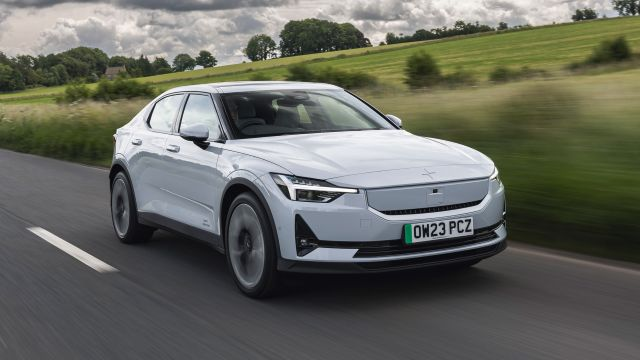

In [14]:
imagefile = os.path.join(IMAGES_DIR, "car1.jpg")

Image(filename=imagefile)

In [15]:
image_emb = get_image_embeddings(imagefile)

In [16]:
df = print_similarity_results(image_emb, prompts)

cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm)

,prompt,cosine_similarity
0,Polestar,0.506660
1,Volvo,0.440660
2,Volkswagen,0.369720
3,Lexus,0.369340
4,Kia,0.366440
5,Audi,0.364260
6,Porsche,0.362170
7,Honda,0.353590
8,Hyundai,0.341660
9,Toyota,0.338640


In [17]:
print(f"This image is a '{df.values.tolist()[0][0]}' car")

This image is a 'Polestar' car


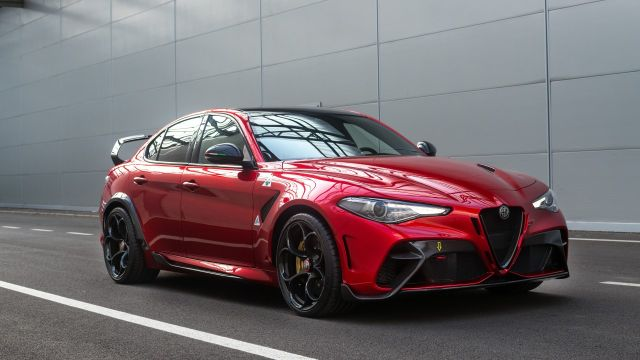

In [18]:
imagefile = os.path.join(IMAGES_DIR, "car2.jpg")

Image(filename=imagefile)

In [19]:
image_emb = get_image_embeddings(imagefile)

In [20]:
df = print_similarity_results(image_emb, prompts)

cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm)

,prompt,cosine_similarity
0,Alfa Romeo,0.450540
1,Ferrari,0.366260
2,Lamborghini,0.350340
3,Lexus,0.343720
4,Kia,0.338290
5,Polestar,0.329630
6,Hyundai,0.307000
7,Audi,0.300620
8,Jaguar,0.297660
9,Toyota,0.296450


In [21]:
print(f"This image is a '{df.values.tolist()[0][0]}' car")

This image is a 'Alfa Romeo' car


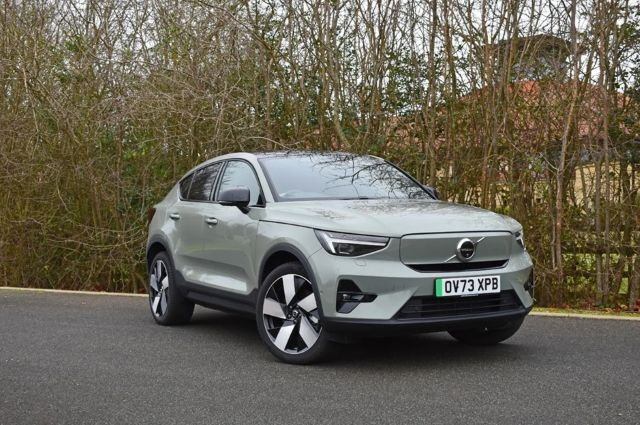

In [22]:
imagefile = os.path.join(IMAGES_DIR, "car3.jpg")

Image(filename=imagefile)

In [23]:
image_emb = get_image_embeddings(imagefile)

In [24]:
df = print_similarity_results(image_emb, prompts)

cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm)

,prompt,cosine_similarity
0,Volvo,0.427610
1,Polestar,0.404090
2,Lexus,0.344940
3,Kia,0.339400
4,Audi,0.325240
5,BMW,0.323030
6,Honda,0.315500
7,Jaguar,0.315040
8,Mazda,0.307230
9,Volkswagen,0.302010


In [25]:
print(f"This image is a '{df.values.tolist()[0][0]}' car")

This image is a 'Volvo' car


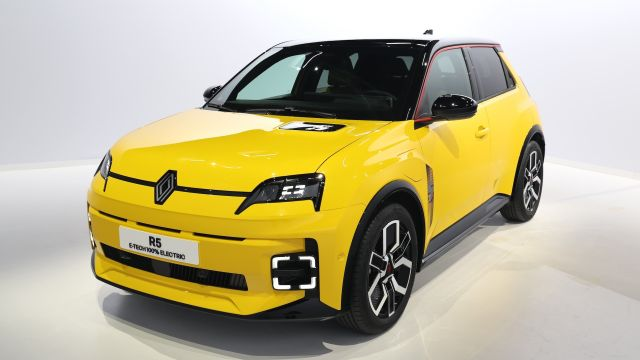

In [26]:
imagefile = os.path.join(IMAGES_DIR, "car4.jpg")

Image(filename=imagefile)

In [27]:
image_emb = get_image_embeddings(imagefile)

In [28]:
df = print_similarity_results(image_emb, prompts)

cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm)

,prompt,cosine_similarity
0,Renault,0.504170
1,Chevrolet,0.356250
2,Kia,0.344790
3,Nissan,0.336740
4,Alfa Romeo,0.336150
5,Mazda,0.330900
6,Toyota,0.328780
7,Porsche,0.326950
8,Audi,0.326900
9,Polestar,0.325810


In [29]:
print(f"This image is a '{df.values.tolist()[0][0]}' car")

This image is a 'Renault' car


# Text embeddings tests

In [30]:
text1 = "Paris"
text2 = "France"
text3 = "This is a car"

In [31]:
get_cosine_similarity(get_text_embeddings(text1), get_text_embeddings(text2))

0.77215

In [32]:
get_cosine_similarity(get_text_embeddings(text1), get_text_embeddings(text3))

0.33298

In [33]:
get_cosine_similarity(get_text_embeddings(text2), get_text_embeddings(text3))

0.31695

In [34]:
get_cosine_similarity(get_text_embeddings(text1), get_text_embeddings(text1))

1.0

# Image embeddings tests

In [35]:
image1 = "images/car4.jpg"
image2 = "images/car5.jpg"
image3 = "images/car1.jpg"

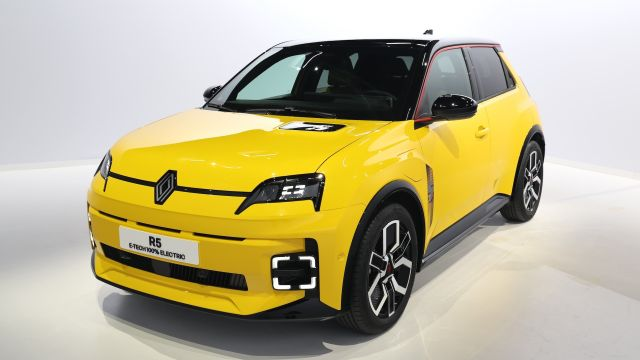

In [36]:
Image(filename=image1)

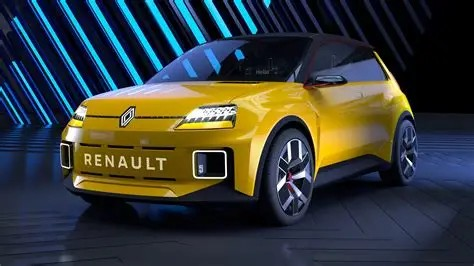

In [37]:
Image(filename=image2)

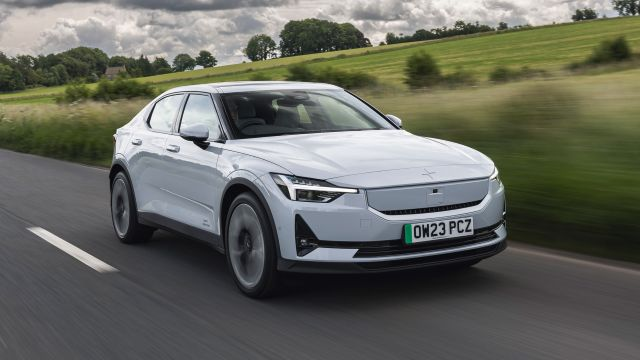

In [38]:
Image(filename=image3)

In [39]:
get_cosine_similarity(get_image_embeddings(image1), get_image_embeddings(image2))

0.89063

In [40]:
get_cosine_similarity(get_image_embeddings(image1), get_image_embeddings(image3))

0.35965

In [41]:
get_cosine_similarity(get_image_embeddings(image1), get_image_embeddings(image1))

1.0

> Go to the next notebook